# Backtest the Kelly strategy for robustness

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from util_kelly import simulate_kelly_strategy, backtest_kelly_strategy, generate_simulation_plots, simulation_boxplot

Here we want to backtest the Kelly Strategy from Notebook "03_analysis_kelly_strategy.ipynb" with parameters found to be near optimal. We will backtest against the historical S&P 500 data.

In [2]:
def optimized_kelly_strategy(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=350, min_kelly=0, max_kelly=10, kelly_fraction=0.4)

Test the strategy ove a horizon of 1, 2, 10, 20, 30 and 40 business years respectivly. We run the strategy on 1000 randomly picked starting dates.

In [4]:
investment_horizon = [252,504,2520,5040,7560,10080]
summary_statistics = pd.DataFrame()
histories = [None for _ in range(len(investment_horizon))]

for i, horizon in enumerate(investment_horizon):
    history, statistics = backtest_kelly_strategy(optimized_kelly_strategy, number_repeats=10000, investment_horizon=horizon)
    summary_statistics[f"date_{i}"] = statistics['date']
    summary_statistics[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics[f"cum_returns_{i}"] = statistics['cum_returns']
    histories[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories[i], f'data/experiment_0/history_{i}.pkl')

pd.to_pickle(summary_statistics, 'data/experiment_0/summary_statistics.pkl')

For the mathematically inclined people among you, the summary statistics are printed below.

In [ ]:
summary_statistics.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.014753,0.033431,0.029993,0.074945,0.447631,0.316024,0.901877,0.639438,1.532474,1.027053,2.145607,1.323825
std,0.001310,0.149263,0.105203,0.230789,0.677206,0.416046,0.960369,0.576800,1.161260,0.701885,1.377490,0.771891
min,0.007622,-0.792134,-1.054514,-1.196014,-1.178207,-0.972626,-1.086094,-0.961487,-0.862552,-0.627459,-0.694813,-0.568743
25%,0.013595,-0.053702,0.027111,-0.045859,-0.082166,0.001307,0.098026,0.206478,0.543360,0.466881,0.894729,0.629080
50%,0.013752,0.050482,0.027346,0.097338,0.300208,0.322959,0.820224,0.577299,1.760453,1.014157,2.509171,1.496616
75%,0.016109,0.127201,0.032291,0.225171,0.896317,0.649420,1.743711,1.108956,2.551332,1.541311,3.190078,2.009253
max,0.016502,0.567020,0.598886,0.808436,2.691445,1.236446,3.256357,1.964335,3.833707,2.687850,4.467138,2.783733


We can see that the Kelly strategy is expected to statistically outperform buy and hold after 20 years, since that is the first time the median cumulative return of the Kelly strategy beats Buy and Hold. We can also see that the risk of running the Kelly strategy is always significantly higher than Buy and Hold (much greater standard deviation).

Now for the visually inclined people the boxplot graphic below. The box shows the range of the 1st to 3rd quartile, the bracket shows the standard deviation the green dotted line shows the median and the orange line shows the mean. The circles outside the boxes represent outliers.

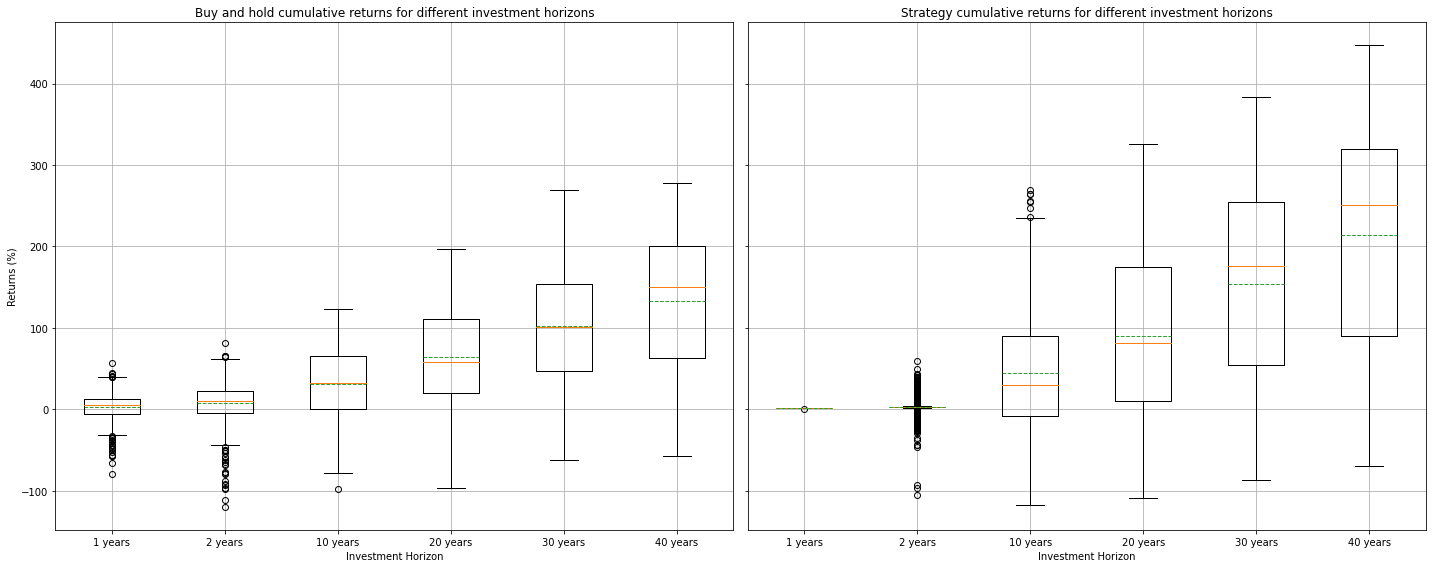

In [ ]:
simulation_boxplot(summary_statistics, investment_horizon=investment_horizon, save_name='plots/cumulative_returns_optimized_strategy.png')

And now for good measure, I show you some of the simulation runs for the 20 year investment horizon.

In [ ]:
history = histories[3] # 20 year simulation
max_samples = 100
generate_simulation_plots(history, max_samples=max_samples, filename="horizon_20y")

In [ ]:
!convert -delay 66 -loop 10 plots/tmp/horizon_20y*.png plots/horizon_20y.gif

![SegmentLocal](plots/horizon_20y.gif)

In [ ]:
def kelly_strategy_1(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
    window=252, min_kelly=0, max_kelly=10, kelly_fraction=0.3)

investment_horizon_1 = [252,504,2520,5040,7560,10080]
summary_statistics_1 = pd.DataFrame()
histories_1 = [None for _ in range(len(investment_horizon_1))]
for i, horizon in enumerate(investment_horizon_1):
    history, statistics = backtest_kelly_strategy(kelly_strategy_1, number_repeats=10000, investment_horizon=horizon)
    summary_statistics_1[f"date_{i}"] = statistics['date']
    summary_statistics_1[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_1[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_1[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_1[i], f'data/experiment_1/history_{i}.pkl')

pd.to_pickle(summary_statistics_1, 'data/experiment_1/summary_statistics.pkl')

In [ ]:
summary_statistics_1.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.014757,0.035375,0.053375,0.066326,0.556809,0.338180,1.195645,0.681383,2.002455,1.013764,2.640997,1.362546
std,0.001390,0.148131,0.153894,0.225715,0.612193,0.410365,0.901104,0.564268,0.945066,0.704131,1.051383,0.760488
min,0.007544,-0.837446,-0.664506,-1.340832,-0.576430,-0.875262,-0.865211,-1.012278,0.282170,-0.617321,0.631090,-0.535562
25%,0.013595,-0.056602,-0.015186,-0.051595,0.108193,0.042333,0.469659,0.228190,1.116999,0.460465,1.758281,0.686418
50%,0.013752,0.055568,0.031450,0.091876,0.425245,0.342738,1.123754,0.652916,2.056477,0.986876,2.825852,1.540450
75%,0.016188,0.137326,0.103026,0.223467,0.991611,0.661669,1.944121,1.143495,2.898589,1.513212,3.408925,2.006766
max,0.016502,0.522657,0.786933,0.575577,2.577005,1.212076,3.511418,1.977434,3.791258,2.693120,4.541636,2.826134


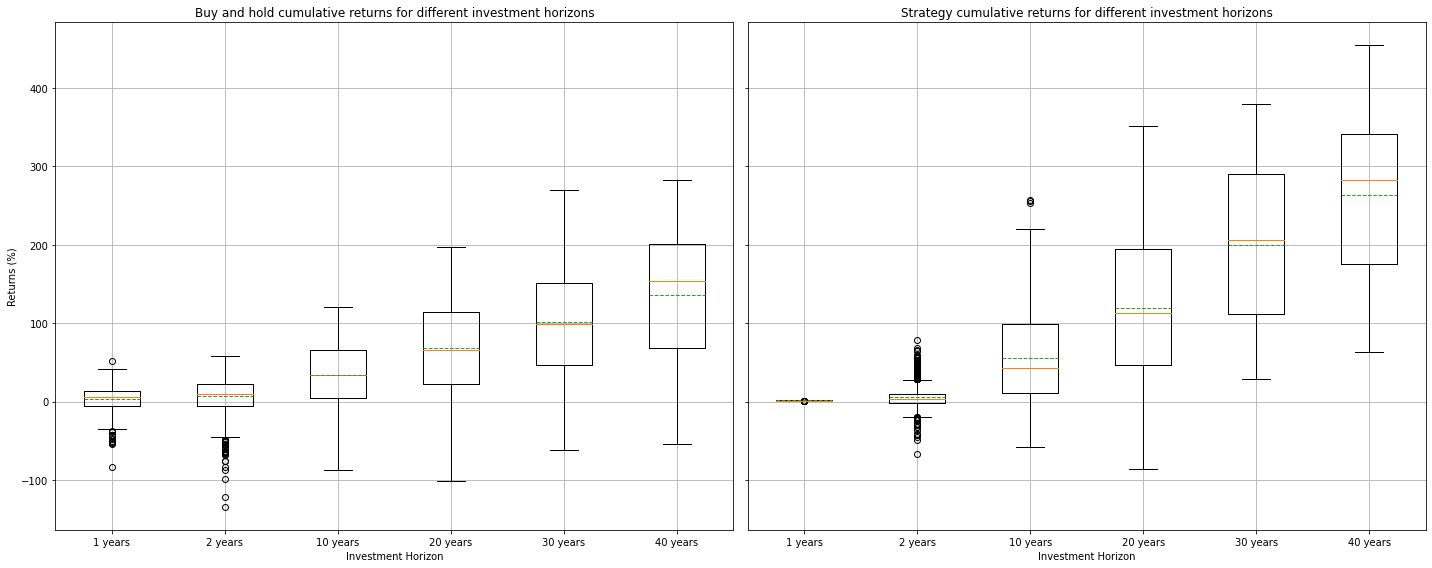

In [ ]:
simulation_boxplot(summary_statistics_1, investment_horizon=investment_horizon_1, save_name='plots/cumulative_returns_strategy_1.png')

In [ ]:
def kelly_strategy_2(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
    window=252, min_kelly=0, max_kelly=10, kelly_fraction=0.5)

investment_horizon_2 = [252,504,2520,5040,7560,10080]
summary_statistics_2 = pd.DataFrame()
histories_2 = [None for _ in range(len(investment_horizon_2))]
for i, horizon in enumerate(investment_horizon_2):
    history, statistics = backtest_kelly_strategy(kelly_strategy_2, number_repeats=10000, investment_horizon=horizon)
    summary_statistics_2[f"date_{i}"] = statistics['date']
    summary_statistics_2[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_2[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_2[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_2[i], f'data/experiment_2/history_{i}.pkl')

pd.to_pickle(summary_statistics_2, 'data/experiment_2/summary_statistics.pkl')

In [ ]:
summary_statistics_2.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.014740,0.037303,0.060864,0.076734,0.630700,0.334164,1.451769,0.636932,2.345685,0.991473,3.263185,1.374803
std,0.001306,0.154002,0.282059,0.214755,0.934537,0.413672,1.437693,0.598509,1.494790,0.680216,1.638876,0.782536
min,0.007544,-0.826542,-1.511195,-1.203560,-1.189003,-0.881859,-1.687238,-1.028365,-0.459743,-0.690922,-0.163665,-0.517652
25%,0.013595,-0.035166,-0.045948,-0.045106,-0.059385,0.029754,0.300837,0.199723,0.989251,0.449674,2.049705,0.643944
50%,0.013752,0.055218,0.031027,0.094511,0.439040,0.337455,1.204703,0.569774,2.323503,0.965355,3.475167,1.544049
75%,0.016109,0.134012,0.125589,0.234344,1.290205,0.681417,2.706205,1.145845,3.666539,1.500142,4.438019,2.037647
max,0.016581,0.455658,1.188919,0.557290,4.005429,1.251524,4.910510,2.000731,5.318902,2.687763,6.182796,2.767802


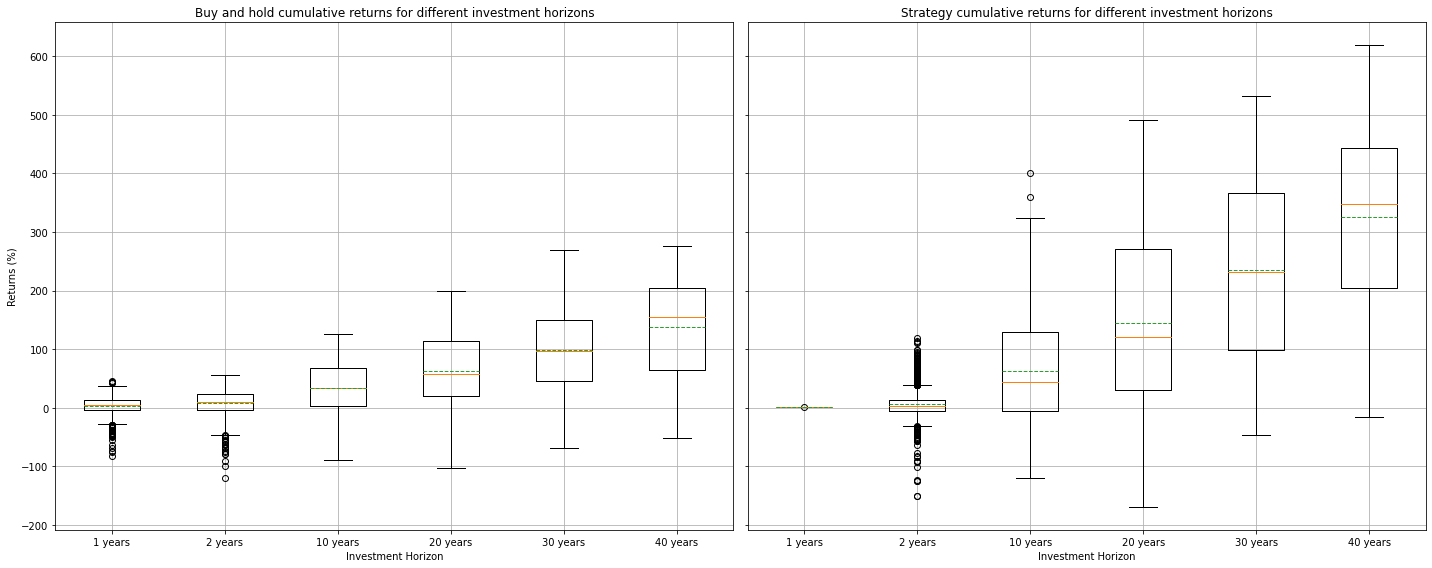

In [ ]:
simulation_boxplot(summary_statistics_2, investment_horizon=investment_horizon_2, save_name='plots/cumulative_returns_strategy_2.png')

In [ ]:
def kelly_strategy_3(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=90, min_kelly=0, max_kelly=10, kelly_fraction=0.3)

investment_horizon_3 = [252,504,2520,5040,7560,10080]
summary_statistics_3 = pd.DataFrame()
histories_3 = [None for _ in range(len(investment_horizon_3))]
for i, horizon in enumerate(investment_horizon_3):
    history, statistics = backtest_kelly_strategy(kelly_strategy_3, number_repeats=10000, investment_horizon=horizon)
    summary_statistics_3[f"date_{i}"] = statistics['date']
    summary_statistics_3[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_3[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_3[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_3[i], f'data/experiment_3/history_{i}.pkl')

pd.to_pickle(summary_statistics_3, 'data/experiment_3/summary_statistics.pkl')

In [ ]:
summary_statistics_3.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.042594,0.035924,0.101023,0.068984,0.552759,0.303495,1.262420,0.654694,1.962660,1.015025,2.629478,1.322206
std,0.163401,0.143782,0.268233,0.219095,0.592682,0.412419,0.772883,0.581711,0.885430,0.664205,1.009691,0.770789
min,-0.527766,-0.632869,-0.557496,-1.176944,-0.700780,-0.985850,-0.485842,-0.983870,0.205387,-0.634401,0.883503,-0.626418
25%,-0.054289,-0.041985,-0.094789,-0.057256,0.127093,0.009129,0.690046,0.214860,1.354929,0.500115,1.857929,0.633544
50%,0.013595,0.055707,0.034491,0.092725,0.415186,0.286378,1.210139,0.593547,1.746624,0.974914,2.461840,1.541818
75%,0.101681,0.121753,0.260299,0.230734,0.973243,0.636627,1.775799,1.135025,2.511338,1.507491,3.214590,1.982684
max,0.703389,0.523972,1.037307,0.683172,2.379879,1.239011,3.711086,2.029106,4.317105,2.684738,4.957989,2.832103


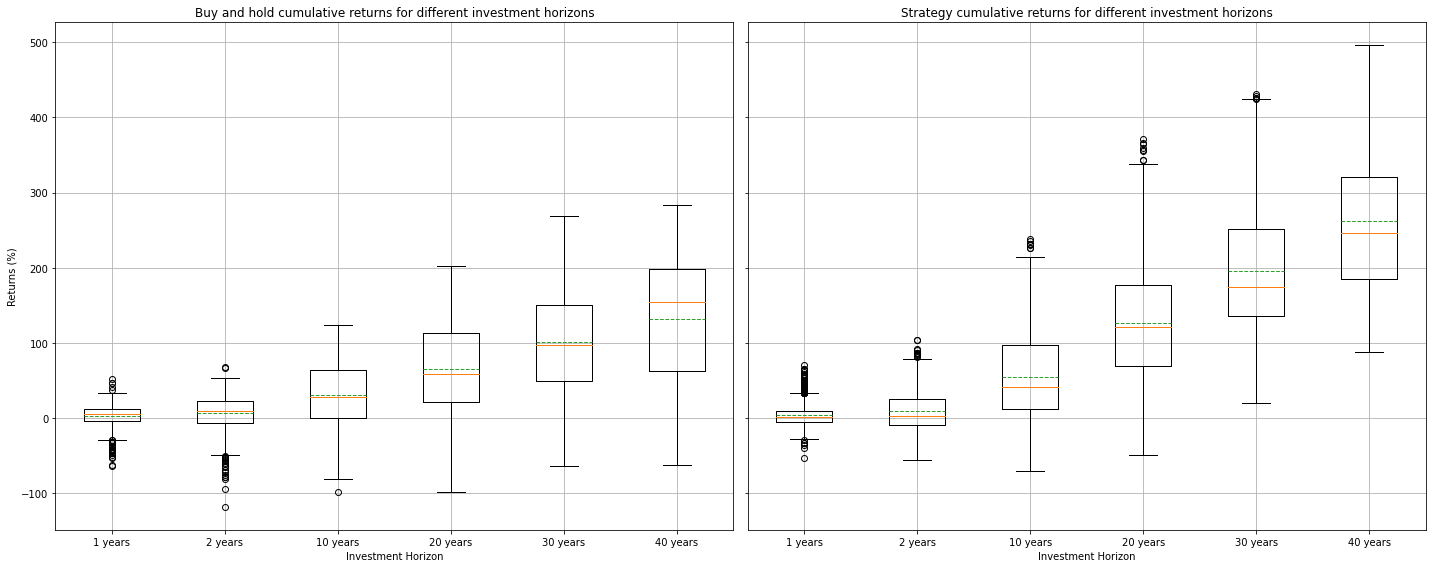

In [ ]:
simulation_boxplot(summary_statistics_3, investment_horizon=investment_horizon_3, save_name='plots/cumulative_returns_strategy_3.png')

In [ ]:
def kelly_strategy_4(data):
    return simulate_kelly_strategy(data, rebalancing_interval=1, annual_risk_free_rate=0.02,\
     window=60, min_kelly=0, max_kelly=15, kelly_fraction=0.2)

investment_horizon_4 = [252,504,2520,5040,7560,10080]
summary_statistics_4 = pd.DataFrame()
histories_4 = [None for _ in range(len(investment_horizon_4))]
for i, horizon in enumerate(investment_horizon_4):
    history, statistics = backtest_kelly_strategy(kelly_strategy_4, number_repeats=10000, investment_horizon=horizon)
    summary_statistics_4[f"date_{i}"] = statistics['date']
    summary_statistics_4[f"strategy_cum_returns_{i}"] = statistics['strategy_cum_returns']
    summary_statistics_4[f"cum_returns_{i}"] = statistics['cum_returns']
    histories_4[i] = history[i][['Date','Close','kelly_factor','strategy_cum_returns','cum_returns']]
    pd.to_pickle(histories_4[i], f'data/experiment_4/history_{i}.pkl')

pd.to_pickle(summary_statistics_4, 'data/experiment_4/summary_statistics.pkl')

In [ ]:
summary_statistics_4.describe()

,strategy_cum_returns_0,cum_returns_0,strategy_cum_returns_1,cum_returns_1,strategy_cum_returns_2,cum_returns_2,strategy_cum_returns_3,cum_returns_3,strategy_cum_returns_4,cum_returns_4,strategy_cum_returns_5,cum_returns_5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.048262,0.036637,0.114737,0.058253,0.664392,0.324455,1.437531,0.669769,2.177460,0.990464,2.919842,1.391292
std,0.158025,0.152225,0.255325,0.213006,0.506786,0.424961,0.633525,0.565466,0.711715,0.695124,0.761615,0.785782
min,-0.358831,-0.837446,-0.389045,-1.214187,-0.421761,-0.919995,-0.033811,-0.970290,0.253026,-0.708825,0.885430,-0.564611
25%,-0.051571,-0.040114,-0.074676,-0.059442,0.294237,0.018247,0.956057,0.248440,1.711075,0.436512,2.423595,0.685382
50%,0.006826,0.057862,0.069119,0.073694,0.590802,0.344091,1.380763,0.615645,2.197617,0.942880,3.109830,1.552724
75%,0.120869,0.125707,0.240678,0.202646,1.017401,0.656104,1.944358,1.131110,2.746712,1.491384,3.509841,2.064618
max,0.766841,0.466374,1.063548,0.558389,2.184179,1.240484,2.866134,2.001583,3.740104,2.644927,4.157595,2.700938


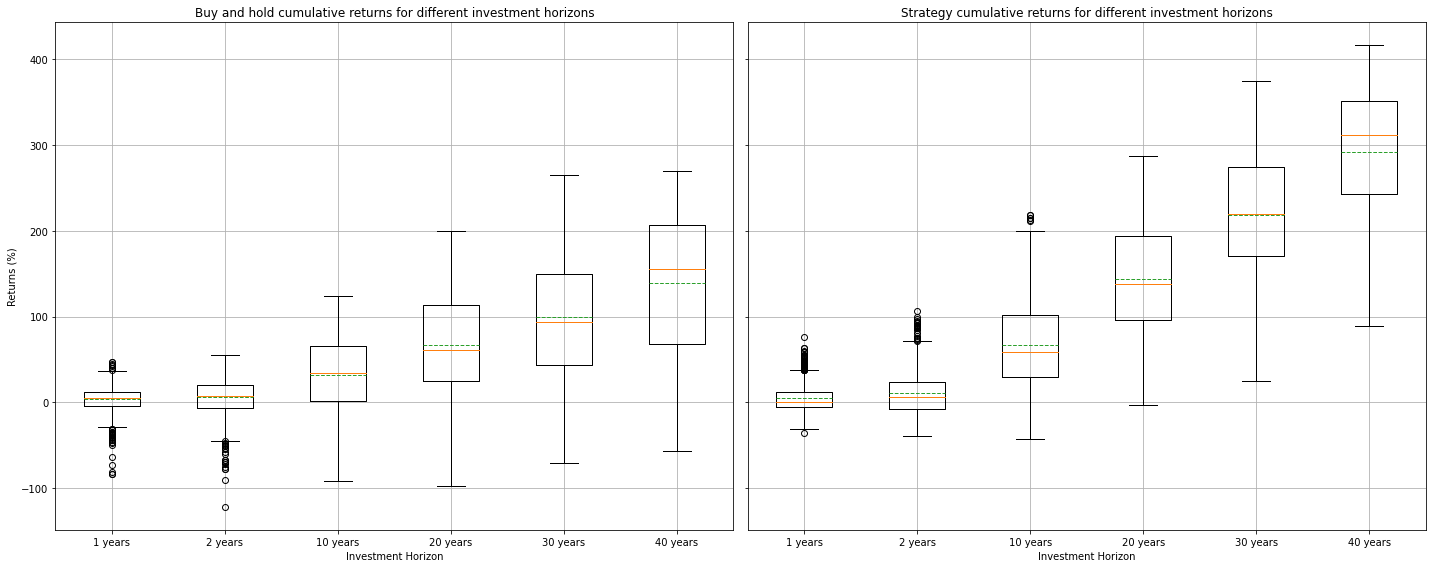

In [ ]:
simulation_boxplot(summary_statistics_4, investment_horizon=investment_horizon_4, save_name='plots/cumulative_returns_strategy_4.png')